In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import math
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns


In [4]:
sys.path.append('./../src/')
from aging_tools import calculators, inout, export

In [5]:
out_path = '191106_flynn_box'

In [6]:
from access_science_shared import mapper

In [7]:
from access_biology_data import meta, relations, properties



In [8]:
save_images = False

In [9]:
from scipy.stats import spearmanr

In [10]:
p = inout.get_internal_path(
    'datasets/general/complementary/191021_flynn_slack_by_rgrant/' +
    '191019_Flynn_AgingCell_2013_age_2_rapamycin_vs_1_control_dge.csv')

In [11]:
df = pd.read_csv(p)

In [12]:
df = df[df['padj']<0.05]

In [13]:
df

,Unnamed: 0,mgi_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,entrezgene_id
52,53,1190002F15Rik,9.098542,-1.232999,0.366116,-3.367786,0.000758,0.017855,NaN,NaN
96,97,1700001J03Rik,6.571017,1.068576,0.362782,2.945503,0.003224,0.043095,ENSMUSG00000095040,69282.0
246,247,1700026L06Rik,10.690927,-3.913135,0.953175,-4.105369,0.000040,0.002571,NaN,NaN
301,302,1700040L02Rik,329.780243,0.369403,0.122498,3.015594,0.002565,0.037575,NaN,NaN
471,472,1810011O10Rik,2035.419561,0.313869,0.086471,3.629737,0.000284,0.009252,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
24677,24678,Zfp593,62.715383,-0.422639,0.132701,-3.184885,0.001448,0.026954,ENSMUSG00000028840,68040.0
24678,24679,Zfp595,130.814244,-0.399028,0.136454,-2.924257,0.003453,0.044981,ENSMUSG00000057842,218314.0
24691,24692,Zfp612,720.857606,0.384503,0.129606,2.966706,0.003010,0.041177,ENSMUSG00000044676,234725.0
24775,24776,Zfp787,465.668333,0.246180,0.066972,3.675866,0.000237,0.008348,ENSMUSG00000046792,67109.0


In [14]:
df = df.rename(columns={
    'entrezgene_id': 'gene_ncbi',
    'log2FoldChange': 'log2FoldChange'
})

In [15]:
df = df[['gene_ncbi', 'log2FoldChange']].dropna()

In [16]:
df = df.groupby('gene_ncbi').agg(np.median).reset_index()

In [17]:
# df = mapper.symbol_2_gene_ncbi(df, 9606, how='median').reset_index()

In [18]:
from access_biology_data import meta, relations, properties



In [19]:
pr = properties.genbank_validated_rna(10090)[
    ['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])

In [20]:
from access_science_shared import standardizer

In [21]:
ref_genes=standardizer.reference_genes(10090, 'orp')

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [22]:
m = pd.merge(df, pr)
m = m[m['gene_ncbi'].isin(ref_genes)]

In [23]:
(m['log2FoldChange']<0).sum()

662

In [24]:
(m['log2FoldChange']>0).sum()

291

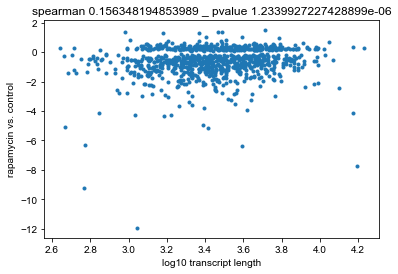

In [25]:

plt.figure()
plt.plot(m['log_length'], m['log2FoldChange'], '.')

r, p = spearmanr(m['log_length'], m['log2FoldChange'])
plt.title('spearman {} _ pvalue {}'.format(r, p))
plt.xlabel('log10 transcript length')
plt.ylabel('rapamycin vs. control')


if save_images:
    export.export_image('{}/scatter.pdf'.format(out_path))

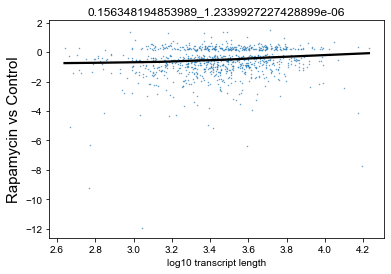

In [26]:
sns.regplot(
    x='log_length',
    y='log2FoldChange',
    data=m,
    scatter_kws={'s': 0.2},
    line_kws={'color': 'black'},
    lowess=True
)



plt.xlabel('log10 transcript length')
plt.ylabel('Rapamycin vs Control', fontsize=15)

plt.title('{}_{}'.format(r, p))

if save_images:
    export.export_image('{}/small_dots_and_regression.pdf'.format(out_path))

In [27]:
m.loc[:, 'is_induced'] = m['log2FoldChange'] > 0

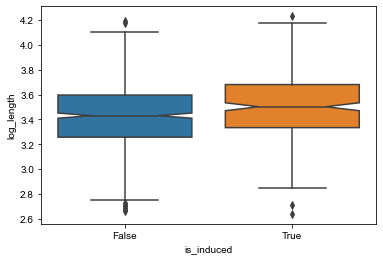

In [28]:
sns.boxplot(x='is_induced', y='log_length', data=m, notch=True)


if save_images:
    export.export_image('{}/boxplots.pdf'.format(out_path))

In [29]:
from scipy.stats import mannwhitneyu

In [30]:
mannwhitneyu(
    m[m['is_induced']==False]['log_length'],
    m[m['is_induced']==True]['log_length'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=79623.0, pvalue=1.9838239808037084e-05)

In [31]:
m['is_induced'].value_counts()

False    662
True     291
Name: is_induced, dtype: int64